# Modeling , Param Tuning, Evulating, Explaining & Prediction

In [135]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from datetime import datetime
import pickle 
import warnings
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss,roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import category_encoders as ce
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
import shap
import json
import imblearn

import DATA_PROCESSING as process
%pylab inline
pd.set_option('display.max_rows', 500)

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['identity', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy


# Running parameters

In [139]:
SAMPLE = 2000
USE_SMOTE = True
CALC_PARAMS = True
dev_mode = True
config_file = "configuration_01_15_2022__08_18_sample_1000000.csv"


In [140]:
columns_cum =['app_cat','manufacturer','device_model','device_version','user_isp']
columns_dummies=['banner_pos', 'Day_of_Week','state','manufacturer','Month','hour','user_isp','app_cat','device_model','device_version']
features = ['state', 'user_isp', 'app_cat', 'banner_pos', 'manufacturer', 'device_model', 'device_version', 'device_height', 'device_width', 'device_diag', 'Day_of_Week', 'Month', 'hour']
cat_features = ['state', 'user_isp', 'app_cat', 'banner_pos', 'manufacturer', 'device_model', 'device_version', 'Day_of_Week', 'Month', 'hour']

# Read Training Data

In [141]:
df = pd.read_pickle("train_set.pickle").sample(n=SAMPLE)
df.loc[:,"clicked"] = df.loc[:,"clicked"].map({True:1, False:0})

### Imputing, Feature engineering,Cardinality reductions , and dummy coding 

In [142]:
def preprocessing_pipeline(df, one_hot_encoding=True, allowed_levels_dict = None):
    df= df.drop(['op_id', 'resolution','app_id'], axis=1)
    # if  a dict of categorical columns and theyr allowed levels is given - replace levels not in the list as "<col_name>_other"
    if allowed_levels_dict:
        for col_name, categories_list in allowed_levels_dict.items():
            df.loc[:, col_name] = df[col_name].map(lambda x: x if x in categories_list else f"{col_name}_other")
    df=process.Missing_values(df)
    df=process.Feature_engineering(df)
    if not allowed_levels_dict:
        df, cat_dict = process.cumulatively_categorise(df,columns_cum)
    if one_hot_encoding:
        df=process.get_dummies_fun(df,columns_dummies)
    return df,allowed_levels_dict if allowed_levels_dict else cat_dict 

In [143]:
%%time
df, allowed_levels_dict = preprocessing_pipeline(df, one_hot_encoding=USE_SMOTE)
MODEL_COLS = list(df.columns)
df.shape

summary of missing values before imputing missing data: 
manufacturer    646
device_model    646
dtype: int64
summary of missing values after imputing missing data based on device version
manufacturer    74
device_model    74
dtype: int64
summary of missing values after imputing missing data by assigning a separate category
Series([], dtype: int64)
Wall time: 2.48 s


(2000, 224)

# exploring the Target Encoder

for classification tasks Target encoding is a novel and usefull method for converting high-cardinality categorical variable to a continuous value by encoding for each level the propoprion of rows in which Y=1\
i.e. for click prediction it encodes the ctr for each level over the entire dataset



encoder = ce.TargetEncoder(cols=cat_features)
encoded = encoder.fit_transform(df[features], df['clicked'])
encoded.describe()

# look at Class (Im)Balance

In [144]:
df.groupby('clicked').clicked.count()

clicked
0    1871
1     129
Name: clicked, dtype: int64

# splitting the data test to 3 parts:
1. training: 80%
2. validation: 10% - for param running 
3. test set: 10% a final test set to evaluate the perfromance of the final model, only after all tunning has completed.

In [145]:
train_df, other = train_test_split(df, test_size=0.2, random_state=42)
dev_val, dev_test = train_test_split(other, test_size=0.5, random_state=42)


In [146]:
train_df.shape, dev_val.shape,  dev_test.shape

((1600, 224), (200, 224), (200, 224))

# SMOTE oversampling - on the training set only

In [147]:
def appply_smote(df):
    cat_features =  [c for c in df.columns if 'device_' not in c and c != 'clicked']
    features =  [c for c in df.columns if c != 'clicked']
    
    kw_args={
                'y':df['clicked'],
                'X_cols' :list(df[features].columns),
                'y_cols' :list(df[['clicked']].columns)
            }
    smote_transformer = FunctionTransformer(process.Smote_alg,kw_args=kw_args,validate=True)

    smote_pipe = Pipeline([('smote', smote_transformer)])
    new_df, new_y = smote_pipe.fit_transform(df[features])

    #print ('Before', df[features].shape, df['clicked'].shape, 'After', new_df.shape, new_y.shape)
    
    new_df.loc[:, 'clicked'] = new_y['clicked']
    df = new_df[MODEL_COLS]
    cat_features = []
    return df, features, cat_features



In [148]:
#TODO add the explanation here
if USE_SMOTE:
    train_df, features, cat_features = appply_smote(train_df)
    

org X.shape (1600, 223) len(X_cols) 223
new_X.shape (2994, 223)


In [149]:
dev_val.head()

,device_height,device_width,clicked,device_diag,bottom,bottom-left,bottom-right,center,left,right,...,Z971,Z981,Z982,Z983,device_model_other,6.0.1,7.0,7.1.1,8.0.0,device_version_other
1198,720,1280,0,45.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
720,1536,864,0,37.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1381,720,1280,1,45.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
63,854,480,0,26.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
630,480,854,0,26.0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [150]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2994 entries, 0 to 2993
Columns: 224 entries, device_height to device_version_other
dtypes: float64(223), int64(1)
memory usage: 5.1 MB


In [151]:
X_train = train_df[features]
y_train = train_df['clicked']
X_val = dev_val[features]
y_val = dev_val['clicked']


In [152]:
def get_config(model):
    d = configs.loc[model].params
    params = json.loads(d)
    print (params)
    return (params)
configs = pd.read_csv(config_file).set_index('index')
configs

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
index,,,,,,,
RF,0.93263,0.002963,0.714286,0.836871,-2.326877,0.220281,"{""class_weight"": null, ""criterion"": ""gini"", ""m..."
knn,0.93254,0.001778,0.571429,0.839289,-2.329986,0.340000,"{""leaf_size"": 30, ""n_neighbors"": 1000, ""weight..."
catboost,0.93301,0.007409,1.000000,0.868186,-2.313753,0.947592,"{""min_data_in_leaf"": 100, ""depth"": 8, ""l2_leaf..."


# Preparing for pipeline creation

In [153]:
def plot_auc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.3f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

In [154]:

def plot_calibration(y, y_hat):
    # reliability diagram
    fop, mpv = calibration_curve(y, y_hat, n_bins=10, normalize=True)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pyplot.plot(mpv, fop, marker='.')
    plt.xlabel("Mean predicted probabilities")
    plt.ylabel("True Probabilities")
    plt.title("Calibration Curve")
    pyplot.show()

In [155]:
def find_threshold_by_accuracy(y, y_hat, plot=False):
    threshold = []
    accuracy = []
    for p in np.sort(np.unique(y_hat))[-50:]:
        threshold.append(p)
        y_pred = (y_hat >= p).astype(int)
        curr_accuracy = accuracy_score(y,y_pred)
        accuracy.append(curr_accuracy)
    best_threshold = threshold[np.argmax(np.array(accuracy), axis=0)]
    best_accuracy = max(accuracy)
    print ("Best Threshold:" ,best_threshold, ", with accuracy = ", best_accuracy)
    if plot:
        plt.scatter(threshold,accuracy)
        plt.xlabel("Threshold")
        plt.ylabel("Accuracy")
        plt.show()
    return best_accuracy, best_threshold

In [156]:

def find_best_params_random_forest(grid, X_train, y_train, X_val, y_val):
    best_metric = float('-inf')
    worst_metric = float('inf')
    for g in ParameterGrid(grid):
        print(g)
        rf_pipe = make_rf_pipe_line(None, params = g, target_encoding = (USE_SMOTE == False))
        rf_pipe.fit(X_train,y_train)
        y_hat = rf_pipe.predict_proba(X_val)[:,1]
        #curr_metric, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_hat, pos_label=1)
        curr_metric = auc(fpr, tpr)
        # save if best
        if curr_metric > best_metric:
            best_metric = curr_metric
            best_grid = g
            
        if curr_metric < worst_metric:
            worst_metric = curr_metric
            worst_grid = g
    print ("Final Result")
    print ("best metric", best_metric, ", Grid:", best_grid)
    print ("worst metric", worst_metric, ", Grid:", best_grid)
    return best_grid

In [157]:
def evaulate_pipeline(pipe, X, y, params):
    y_hat = pipe.predict_proba(X)[:,1]
    assert y.shape ==  y_hat.shape
    best_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)
    
    y_pred = (y_hat >= best_threshold).astype(int)

 
    fpr, tpr, thresholds = metrics.roc_curve(y, y_hat, pos_label=1)
    auc = plot_auc(fpr, tpr)
    plot_calibration(y, y_hat)
    #plt.hist(y_hat[y_hat >= 0], bins=10, density=False)
    plt.hist(y_hat, bins=100, density=True)
    plt.title("Histogram of predicted probabilities for click")
    plt.show()
   
    result = {
        "Accuracy": accuracy_score(y, y_pred, normalize=True),
        "Recall": recall_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "AUC": auc,
        "-LogLoss(higer is better)": -log_loss(y, y_pred),
        "threshold":   best_threshold,
        "params": json.dumps(params)
    }
    return result
    

In [158]:
identity  = FunctionTransformer(lambda x:x, validate=True)

# Model 1: Random Forest PipeLine

In [159]:
def make_rf_pipe_line(calibration = None, params = None , target_encoding = True):
    assert calibration is None or calibration in ['isotonic', 'sigmoid']
    encoder = ce.TargetEncoder(cols=cat_features) if target_encoding else identity
    rf = RandomForestClassifier(n_estimators = 200, max_depth=5, criterion = "gini", n_jobs = 4,
                                min_samples_split=100,random_state=13)
    if params:
        rf.set_params(**params)
    if calibration is None:
        rf_pipe = Pipeline([('target_enc',encoder),  ('classifier', rf)])
    else:
        calibrated_RF_classifier =  CalibratedClassifierCV(base_estimator=rf, cv=5, method=calibration)
        rf_pipe = Pipeline([('target_enc',encoder),  ('calibrated_classifier', calibrated_RF_classifier)])
    rf_pipe.fit(X_train, y_train)
    return rf_pipe


### Parameters being tuned:
1. min_samples_leaf = the minimal number of observations in a new leaf that are required in order for creating it
2. max_depth        = the maximal depth that is allowed in each tree (# splits a in any directed path)
3. class_weight     = the strategy for creating class weights to handle imbalanced data
4. n_estimators     = the totl number of trees in the forest
5. criterion        = the metric for calculating improvement in information by the node splitting: Gini inequality or entropy

In [160]:
# this is a long step, was executed and saved previously

if CALC_PARAMS:

    if dev_mode:
        rf_params_grid ={'min_samples_leaf': [50, 100], 
                     'max_depth': [3,5] ,
                     'class_weight' : ['balanced'],
                     'n_estimators': [100],
                     'criterion': ["gini"]

                    }     
    else:    
        rf_params_grid ={'min_samples_leaf': [50, 100, 500], 
                         'max_depth': [3,5] ,
                         'class_weight' : ['balanced', None],
                         'n_estimators': [100, 200],
                         'criterion': ["gini"]

                        }
    best_rf_params = find_best_params_random_forest(rf_params_grid, X_train, y_train, X_val, y_val)
else:
    get_config
    best_rf_params = get_config('RF')


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 50, 'n_estimators': 100}
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 100, 'n_estimators': 100}
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 50, 'n_estimators': 100}
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 100, 'n_estimators': 100}
Final Result
best metric 0.7795698924731183 , Grid: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 50, 'n_estimators': 100}
worst metric 0.7319508448540706 , Grid: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 50, 'n_estimators': 100}


In [161]:

rf_pipe = make_rf_pipe_line(calibration = 'sigmoid' if USE_SMOTE else None,
                            params = best_rf_params,
                            target_encoding = (USE_SMOTE==False))


Best Threshold: 0.9861030550888671 , with accuracy =  0.925


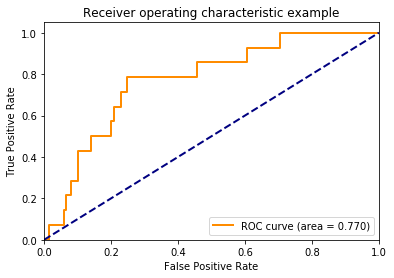

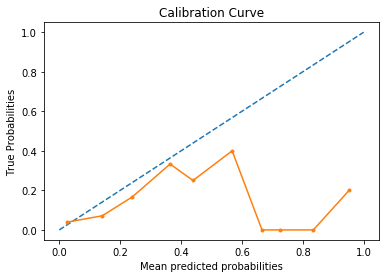

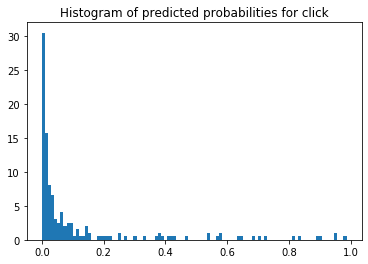

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
RF,0.925,0.0,0.0,0.769969,-2.590412,0.986103,"{""class_weight"": ""balanced"", ""criterion"": ""gin..."


In [162]:
rf_results = evaulate_pipeline(rf_pipe, X_val, y_val,best_rf_params)
rf_df = pd.DataFrame(rf_results, index= ['RF'])
rf_df

# Model 2: CatBoost 

In [163]:
X_val = dev_val[features]
y_val = dev_val['clicked']

In [164]:
validation_pool = Pool(data = X_val, label = y_val, cat_features=cat_features)
train_pool = Pool(data = X_train, label = y_train, cat_features=cat_features)


In [165]:
def make_catboost_pipe_line(train_pool, validation_pool , class_weight = None, target_encoder = False, params = None):
    model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features= cat_features ,
                               depth=5,
                               custom_loss = ['AUC', 'Logloss','BrierScore', 'Precision', 'Recall'],
                               early_stopping_rounds = 20,
                               auto_class_weights = class_weight,
                               subsample= 0.5,
                               verbose=30)
    if params:
        model.set_params(**params)
    model.fit(train_pool, eval_set=validation_pool, plot=True)
    return model


### Parameters being tuned:
1. min_child_samples  = the minimal number of observations in a new leaf that are required in order for creating it
2. depth              = the maximal depth that is allowed in each tree (# splits a in any directed path)
3. l2_leaf_reg        = L2 regularization coeffecient  
4. n_estimators       = the totl number of trees in the forest
5. subsample          = proprtion of rows sampled in each tree growin


In [166]:
if dev_mode:
    catboost_params_grid ={ 
                      'depth': [4,6,8] ,
                      'min_child_samples' : [100,500],
                      'n_estimators': [100],
                      'subsample': [0.95],
                      'l2_leaf_reg':[1],

                    }
else:     
    catboost_params_grid ={ 
                      'depth': [4,6,8] ,
                      'min_child_samples' : [100,500,1000],
                      'n_estimators': [100,200],
                      'subsample': [0.75,0.95],
                      'l2_leaf_reg':[1,2],

                    }


In [167]:
model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               early_stopping_rounds = 20,
                               auto_class_weights = 'Balanced',
                               subsample= 0.5,
                               verbose=30)
if CALC_PARAMS:

    search_results = model.randomized_search(catboost_params_grid,
                      train_pool,
                      y=None,
                      cv=3,
                      n_iter=10,
                      partition_random_seed=0,
                      calc_cv_statistics=True,
                      search_by_train_test_split=True,
                      refit=True,
                      shuffle=True,
                      stratified=None,
                      train_size=0.8,
                      verbose=False,
                      log_cout=sys.stdout,
                  log_cerr=sys.stderr)

    best_catboost_params = search_results['params']
    best_catboost_params

else:
    best_catboost_params = get_config('catboost')

0:	learn: 0.6655900	test: 0.6656069	best: 0.6656069 (0)	total: 11.3ms	remaining: 1.12s
30:	learn: 0.2972656	test: 0.3034598	best: 0.3034598 (30)	total: 268ms	remaining: 597ms
60:	learn: 0.2111396	test: 0.2153031	best: 0.2153031 (60)	total: 539ms	remaining: 344ms
90:	learn: 0.1714366	test: 0.1751437	best: 0.1751437 (90)	total: 802ms	remaining: 79.4ms
99:	learn: 0.1601046	test: 0.1644072	best: 0.1644072 (99)	total: 880ms	remaining: 0us

bestTest = 0.1644071811
bestIteration = 99

0:	learn: 0.6350542	test: 0.6354593	best: 0.6354593 (0)	total: 20.8ms	remaining: 2.06s
30:	learn: 0.2355973	test: 0.2450299	best: 0.2450299 (30)	total: 617ms	remaining: 1.37s
60:	learn: 0.1613757	test: 0.1737727	best: 0.1737727 (60)	total: 1.21s	remaining: 774ms
90:	learn: 0.1263177	test: 0.1413419	best: 0.1413419 (90)	total: 1.82s	remaining: 181ms
99:	learn: 0.1184946	test: 0.1338363	best: 0.1338363 (99)	total: 2s	remaining: 0us

bestTest = 0.1338362942
bestIteration = 99

0:	learn: 0.6408078	test: 0.6419917	be

### optimized configuration for catboost

In [168]:
best_catboost_params

{'min_data_in_leaf': 100,
 'depth': 8,
 'l2_leaf_reg': 1,
 'iterations': 100,
 'subsample': 0.95}

### Train a final cat boost model with the optimized params

In [169]:
catboost_pipe = make_catboost_pipe_line(train_pool, validation_pool, target_encoder = False, params = best_catboost_params)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6447516	test: 0.6395532	best: 0.6395532 (0)	total: 63.8ms	remaining: 6.31s
30:	learn: 0.2113015	test: 0.2878995	best: 0.2878995 (30)	total: 2s	remaining: 4.44s
60:	learn: 0.1246362	test: 0.2412312	best: 0.2412312 (60)	total: 3.84s	remaining: 2.45s
90:	learn: 0.0901467	test: 0.2219535	best: 0.2219535 (90)	total: 5.74s	remaining: 568ms
99:	learn: 0.0838131	test: 0.2201303	best: 0.2201303 (99)	total: 6.29s	remaining: 0us

bestTest = 0.2201302577
bestIteration = 99



Best Threshold: 0.4332758547993312 , with accuracy =  0.925


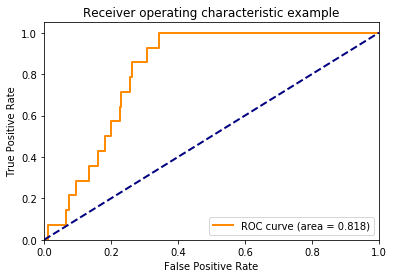

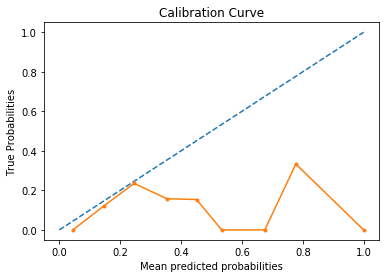

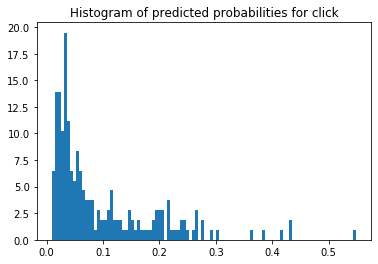

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
catboost,0.925,0.071429,0.333333,0.817588,-2.590416,0.433276,"{""min_data_in_leaf"": 100, ""depth"": 8, ""l2_leaf..."


In [170]:
catboost_results = evaulate_pipeline(catboost_pipe, X_val, y_val, best_catboost_params)
catboost_df = pd.DataFrame(catboost_results, index= ['catboost'])
catboost_df

# Model 3: KNN Classifier 

In [171]:
def make_knn_pipe_line(params = None) :
    encoder = ce.TargetEncoder(cols=cat_features)
    knn_model = KNeighborsClassifier(n_neighbors=300, weights='uniform')
    if params:
        knn_model.set_params(**params)
    return (Pipeline([('target_enc',encoder),  ('scaler',  StandardScaler()), ('KNN', knn_model)]))   

In [172]:
def find_best_params_knn(grid,X_train, y_train, X_val, y_val):
    best_metric = float('-inf')
    worst_metric = float('inf')
    for g in ParameterGrid(grid):
        print(g)
        model = make_knn_pipe_line(params = g)
        model.fit(X_train, y_train)
        y_hat = model.predict_proba(X_val)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_hat, pos_label=1)
        curr_metric = auc(fpr, tpr)

        # save if best
        if curr_metric > best_metric:
            best_metric = curr_metric
            best_grid = g
            
        if curr_metric < worst_metric:
            worst_metric = curr_metric
            worst_grid = g
    print ("Final Result")
    print ("best AUC metric", best_metric, ", Grid:", best_grid)
    print ("worst AUC metric", worst_metric, ", Grid:", worst_grid)
    return best_grid

### Parameters being tuned:
1. n_neighbors        = number of nearset neighbouring observation to consider for deciding on the prediciton
2. weights       = should all neighbours have equal weight or weighted by the distance to the observation


In [173]:
%%time
# Note: previous runs showed that uniform weighting is consistently better than distanced based weighting
# hence due to slow perfromance of this classifier, we avoid the distance based weighting option
if CALC_PARAMS:
    if dev_mode:
        knn_params_grid ={'n_neighbors': [500], 
                         'weights': ['uniform']
                        }
    else:
        knn_params_grid ={'n_neighbors': [500, 1000, 1500], 
                 'weights': ['uniform']
                }
    best_knn_params = find_best_params_knn(knn_params_grid, X_train, y_train, X_val, y_val)
    best_knn_params
else:
    best_knn_params = get_config('knn')

{'n_neighbors': 500, 'weights': 'uniform'}
Final Result
best AUC metric 0.8396697388632872 , Grid: {'n_neighbors': 500, 'weights': 'uniform'}
worst AUC metric 0.8396697388632872 , Grid: {'n_neighbors': 500, 'weights': 'uniform'}
Wall time: 373 ms


In [174]:
knn_pipeline = make_knn_pipe_line(params = best_knn_params)
knn_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('target_enc',
                 TargetEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               min_samples_leaf=1, return_df=True,
                               smoothing=1.0, verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('KNN',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=500, p=2,
                                      weights='uniform'))],
         verbose=False)

Best Threshold: 0.864 , with accuracy =  0.925


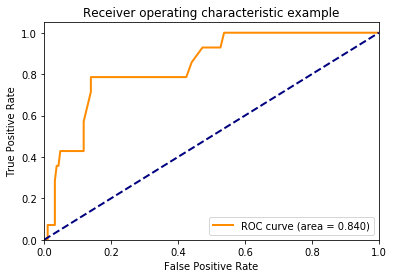

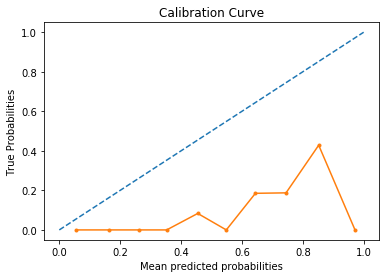

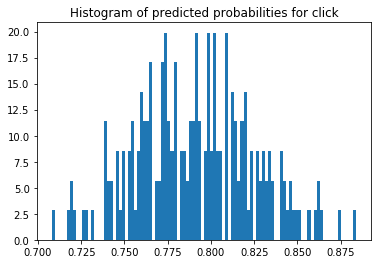

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
knn,0.925,0.071429,0.333333,0.83967,-2.590416,0.864,"{""n_neighbors"": 500, ""weights"": ""uniform""}"


In [175]:
knn_results = evaulate_pipeline(knn_pipeline, X_val, y_val, best_knn_params);
knn_df = pd.DataFrame(knn_results, index= ['knn'])
knn_df

# summary of model metrics

In [176]:

metrics_df = pd.concat([rf_df, knn_df,catboost_df])
metrics_df.sort_values(by='AUC')

if CALC_PARAMS:
    now = datetime.datetime.now()
    now_string = now.strftime("%m_%d_%Y__%H_%M")
    metrics_df.reset_index().to_csv(f"configuration_{now_string}_sample_{SAMPLE}.csv", index=False)
metrics_df

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
RF,0.925,0.000000,0.000000,0.769969,-2.590412,0.986103,"{""class_weight"": ""balanced"", ""criterion"": ""gin..."
knn,0.925,0.071429,0.333333,0.839670,-2.590416,0.864000,"{""n_neighbors"": 500, ""weights"": ""uniform""}"
catboost,0.925,0.071429,0.333333,0.817588,-2.590416,0.433276,"{""min_data_in_leaf"": 100, ""depth"": 8, ""l2_leaf..."


# Exaplinable AI:  Shap Values

In [177]:
model = catboost_pipe


# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.initjs()


### Overview Of Shap
- Shap Values (Shapely Additive exPlanations) is a model Agnostic method for explaining model predictions\
It is based on theory developed by Loid Shapley in the 1950's
- Shap explains a model output additivley as the sum of each variables contribution
- shap is model agnostic but has fast implementations for tree based models
- Shap is the ONLY explanation method that satisifes a set of basic properties which are natural to be required from any valid explanation method:\
1. Local accuracy: - the shap value for a given observation Xi is equal to the model prediction for Xi
2. Missingness:  A missing value has zero contribution in the explanation
3. Consistency: If the importance of a variable in model B is not smaller than in model A then its shap value for model B will not be lower than for model A


## Shap Summary Plot

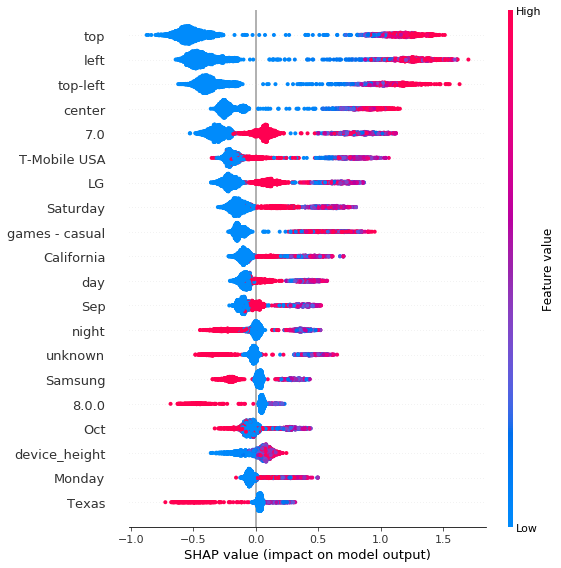

In [178]:

shap.summary_plot(shap_values)

#### explanation
This graph is actually a series of dot-plots:every observation(row) is representated as a dot
for each variable in the model we have a dot-plot showing a dot for each observation in the train set
X-axis: The shap value i.e. the negative or positive contribution of the observation's variable to the final prediction
Y-axis: in case where many observation have the same shap value the dots are stacked vertically
Color: For continuous variables the color represent whether the value of the variable is high or low in the observation

##### Example: TODO verify
in the device_diag variable we see that large screens (strong red) are associated with increased (positive) probability for a click

In [179]:

def explain_simple(idx, X_train):
    data = X_train.iloc[[idx]]
    shap_values = explainer.shap_values( data)
    return (shap.force_plot(explainer.expected_value,shap_values , data, link='logit'))

## 3 random predictions local explanations

In [180]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [181]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [182]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

# Section 8: Prediction on external data set

In [183]:
model = catboost_pipe


In [184]:
testset = pd.read_csv("ctr_dataset_test.csv")

# Apply preprocessing pipeline

In [185]:
%%time

X_test, _ = preprocessing_pipeline(testset, one_hot_encoding=USE_SMOTE, allowed_levels_dict = allowed_levels_dict)




Wall time: 5.94 s


### Add empty dummy columns for levels that are possibly missing in the predicitons data set

In [186]:
MODEL_COLS.remove('clicked')
unknown_cols = [c for c in MODEL_COLS  if c not in X_test.columns ]
for c in unknown_cols:
    print(f"adding default column for {c}")
    X_test.loc[:, c] = 0

adding default column for Missing_device_model
adding default column for 7.0


In [187]:
print ([c for c in X_test.columns if c not in MODEL_COLS])
X_test = X_test[MODEL_COLS]


[]


In [188]:
y_hat = model.predict_proba(X_test)

In [189]:
best_threshold_catboost = catboost_df['threshold'].values[0]
best_threshold_catboost

0.4332758547993312

In [190]:
y_pred = (y_hat[:,1] >= best_threshold_catboost).astype(int)
predictions = pd.Series(y_pred)

#### Total predictions , total clicks predicted,  Percentage of predicted clicks:

In [191]:
f"N={predictions.count()}, Clicks={predictions.sum()}, Clicks Percent= {round(predictions.mean()*100,3)}%"

'N=629764, Clicks=1693, Clicks Percent= 0.269%'

# Group 8 output

In [192]:
predictions.to_csv('output_8.txt', index=False)

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [193]:
datetime.datetime.now()

datetime.datetime(2022, 1, 15, 23, 7, 34, 107587)